In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x  + 5

In [3]:
f(3.0)

20.0

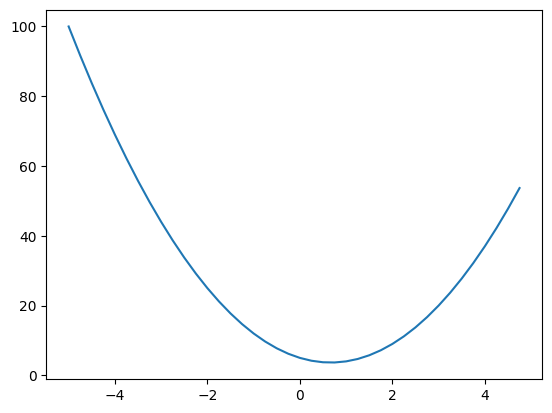

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Finding the slope at a point

In [5]:
x = 3
h = .00001

(f(x + h) - f(x))/h

14.00003000000538

In [6]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


analyzing the slope


In [7]:

h = .0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h

d2 = a*b + c
print(d1)
print(d2)
print((d2 - d1)/h)

4.0
4.0001
0.9999999999976694


In [8]:
class Value:
  def __init__(self, data, _children = (), _op = '', label = ''):
    self.data = data
    self._backward = lambda: None
    self.grad = 0.0 # to initialize backpropagation
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): # returns the value of a value defining object
    return f"Value(data={self.data})"

  def __add__(self, other): # it basically calls a.__add__(b)
    other = other if isinstance(other, Value) else Value(other)
    output = Value(self.data + other.data, (self, other), "+")


    def _backward():
      self.grad += 1.0 * output.grad
      other.grad += 1.0 * output.grad
    output._backward = _backward

    return output

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other): # it basically calls a.__add__(b)
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  def __radd__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # it does other * self
    return self * other

  def __truediv__(self, other):
    return self * (other ** -1)

  def __neg__(self):
    return self * (-1)

  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")


    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    topo

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



a = Value(2.0, label ='a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f ; L.label = 'L'
L

#At this point we know the children of graph but dont know the operations that is in between them so we are adding the _op()

Value(data=-8.0)

In [9]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [10]:
d._op

'+'

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record') #, n.grad
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

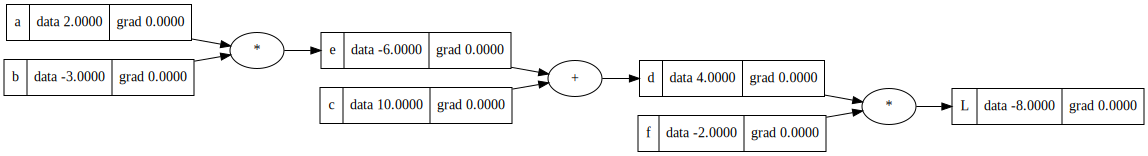

In [12]:
draw_dot(L)

The leaf nodes will be the weights of the neural network

In [13]:
L.grad = 1.0

To manually figure out the gradiant of lets say 'd', we need to find the derivative of L with respect to d. for instance, dL/dd.  
We can figure out the derivative by using the formula;  
--> (f(x+h) - f(x))/h  

--> (f*(d+h) - f * d)/h  

--> (f*d + f*h -- f*d)/h  

--> f

The gradiant of L with respect to d will be the other node;f. and vice versa

.............................................................................

Now if we want to find the derivative of c with respect to L, we need to multiply dL/dd and dd/dc. Now dd/dc will be  
--->  d = c + e
 by differenciating it by c, we will get 1.0.  
 So, dd/dc = 1.0  
 and, dd/de = 1.0  
 Here we can see, when there is plus node, the gradiant will just flow and remain the same.

 ............................................................................

 In the same way, if we want to find dL/da, it will be dL/de * de/da.  
 Here we just need to find de/da.  
 so,  
 dL/da = dL/de * de/da  
= -2.0 * b.data  
= -2.0 * -3.0  

Similarly,  
dL/db = dL/de * de/db  
= -2.0 * a.data  
= -2.0 * 2.0   

.............................................................................  

Now If we want to changew our L, we need to nudge (adding a value h) our leaf nodes in the positive direction. The leaf nodes are the connected ones.

In [14]:
f.grad = -2.0
d.grad = 4.0
c.grad = -2.0
e.grad = 4.0

a.grad = 6.0
b.grad = -4.0

In [15]:
def lol():

  h = 0.001
  a = Value(2.0, label ='a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d * f ; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label ='a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d * f ; L.label = 'L'
  L2 = L.data + h

  print((L2 - L1)/h)

lol()

1.000000000000334


An acrivtion function acts as a squashing function. the inputs gets squashed in a range. here we will be using tanh to demonstrate

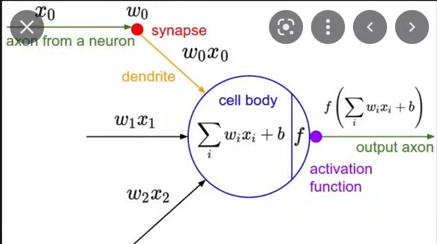

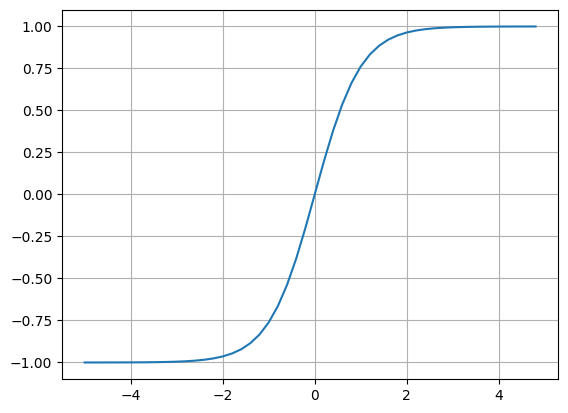

In [16]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [17]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


# Here this N is  the cell body and Now we will get this function through the activation function , O.

# We got, n = 0.88 and o = 0.70. it hasnt been squashed as much as we wanted. So if we increase our bias from 6.88 to 8.0, we get n = 2.0 and o = 0.96. It squashed quite a bit.
# for the sake of nicer number, we gonna use 6.8813735870195432

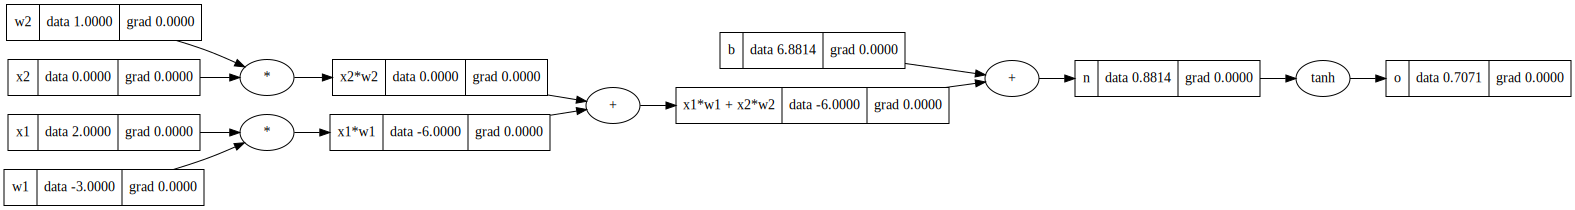

In [18]:
draw_dot(o)

In [19]:
o.backward()

We now know how we can find the gradients but to do that we need to knoq all the children node. for that we will be using topological sort so that we can make sure that all the children nodes exist.

In [20]:
# o.grad = 1.0

# topo = []
# visited = set()
# def build_topo(v):
#   if v not in visited:
#     visited.add(v)
#     for child in v._prev:
#       build_topo(child)
#     topo.append(v)
# build_topo(o)
# topo

# for node in reversed(topo):
#   node._backward()

In [21]:
# o._backward()

In [22]:
# n._backward()

In [23]:
# x1w1x2w2._backward()

In [24]:
# b._backward()

In [25]:
# x1w1._backward()
# x2w2._backward()

### intuitive Things:
here the gradiant of w1 is 1.0. this means that, Our output will change proportionally to w1.

In [26]:
  # Now lets backpropagate.
  # In case of  do/dn, 0 = tanh(n). By formula we get do/dn = 1 - tanh(n)**2
  # or do/dn = 1 - o**2

  # o.grad = 1.0
  # n.grad = 1 - o.data**2

  # x1w1x2w2.grad = 0.5
  # b.grad = 0.5 #As + is a gradiant distributer

  # x1w1.grad = 0.5
  # x2w2.grad = 0.5

  # x1.grad = w1.data * x1w1.grad
  # w1.grad = x1.data * x1w1.grad

  # x2.grad = w2.data * x2w2.grad
  # w2.grad = x2.data * x2w2.grad

Theres a simple bug in nour model. it is showed below

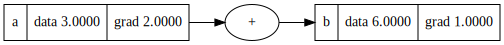

In [27]:
a = Value(3.0, label ='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

In [28]:
a = Value(2.0)
print(a.exp())

Value(data=7.38905609893065)


In [29]:
# If we want to divide, we can just make it a multiplication instead

a = Value(4.0)
b = Value(2.0)
a - b
# a * (1/b)
# a * (b**-1)

Value(data=2.0)

Alright so instead of using tanh directly, we can break it down and use the formula to define our 'o'.

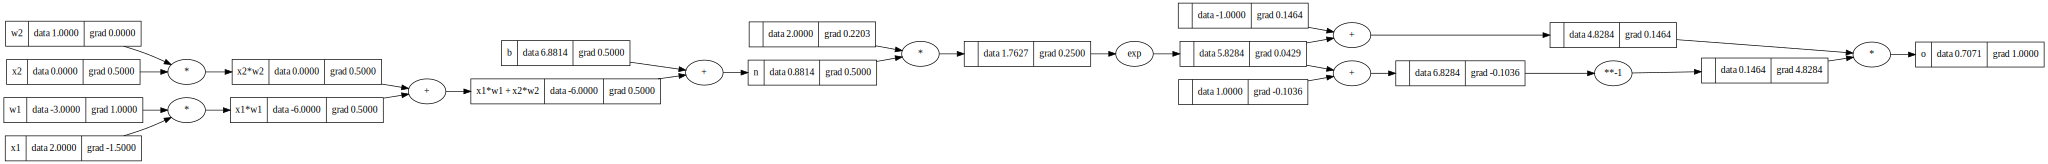

In [30]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#-------------------
e = (2*n).exp()
o = (e-1)/(e+1)
#-------------------
o.label = 'o'
o.backward()
draw_dot(o)

Now we are doing the same thing using the tensor of pytorch.  
Some important things about tensor:  
1. unlike python it uses float32. so we need to double it to get float64.  
2. By default it does not have gradiant mentioned, so we need to manually tell it .


In [31]:
import torch

In [32]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [33]:
import random

class Neuron: # this is a single neuron. And the value we get, is from a single neuron.
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w *x = b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

# we will now create a layer of neurons

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

#MLP = Multilayer perception where the layers just feed into each other sequentially.
#nouts= a list of the size of all the layers that we want in out mlp

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

# x = [2.0, 3.0]
# n = Neuron(2, 3)
# n(x)
#This is the result from a single neuron

# x = [2.0, 3.0]
# n = Layer(2, 3)
# n(x)
#Here 3 outputs are froom 3 neurons in a layer



In [34]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.44035966886079964)

In [35]:
len(n.parameters()) # These are all the parameters of all the neurons we can see by removing the len

41

In [36]:
# draw_dot(n(x))

Okay now we will try to backpropagate our wat and try to find the grad of w and b.  
I feeel soo good! Andrej is showing how to manually do all the things that I just did and accepted.  
Alright, now I will create a small dataset and feed the inputs to my neural network that I just created. It will give me an input. After that I will manuallt tell that this ans that you gave me should be higher or lower.  
LETS DOOO IT

In [37]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.44035966886079964),
 Value(data=0.005068809791667399),
 Value(data=0.31476775910734306),
 Value(data=0.33473144512670666)]

We will calculate the loss, in particular, the mse.

In [38]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=0.3131973002375939),
 Value(data=1.0101633124160387),
 Value(data=1.7286142603881443),
 Value(data=0.4425822501032)]

Now we will summ all the losses to get a universal loss and try to minimize the loss.

In [39]:
ypred = [n(x) for x in xs]
loss =sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss


Value(data=3.4945571231449772)

Now heres another intersting thing. The particular weight of a particular neuron shown below has a grad value when we run .backward and by seeing the grad value we can determine how much influence that neuron is having on the loss. suppose the value is negative 0.2. so by making the value of this neuron slightly possitive, our loss will decrease. AND we can see this for every neuron!! How cool is that??

In [40]:
loss.backward()

n.layers[0].neurons[0].w[0].grad

1.2111917420612444

In [41]:
n.layers[0].neurons[0].w[0].data

0.11704108703733596

## Collecting all of the parameters of the neural nets

Now we have to collect all the parameters so that we can nudge them accordingly. I am doing this in the upper section. Here we can see that, I multiplied a very small amount with the gradient of the data which is called a step. As the gradient is in minus, so if we want to reduce the loss, we aim to make the gradiant 0, and to make this, wee need to multiply with a very small but negative number.

In [42]:
  for p in n.parameters():
    p.data += -0.01 * p.grad

In [43]:
n.layers[0].neurons[0].w[0].data

0.10492916961672351

Now lets check if the loss has been reduced

In [44]:
ypred = [n(x) for x in xs]
loss =sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss
# It hassssssssssss! Congo to me and andrej karpathy.

Value(data=3.045840930485059)

Okay another interesting thing. The above cell is for forward pass. If we again run loss.backward and then run the above cell, the loss should be even lower. it will learn all over again. The below 3 cells is the loop we need to iterate multiple times

In [45]:
#Forward pass
ypred = [n(x) for x in xs]
loss =sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.045840930485059)

In [46]:

#backward pass
loss.backward()

In [47]:
#Update
for p in n.parameters():
  p.data += -0.01 * p.grad

In [48]:
# Here we can see that we almost got our desired output
ypred

[Value(data=0.41881007145561927),
 Value(data=-0.13391168172836881),
 Value(data=0.22274151834979677),
 Value(data=0.31966669808050147)]

Now lets make it respectable. Lets form a loop.  
One more thing, we need to reset the grad everytime because we are not adding the grad, we need to update the new grad

In [49]:
for i in range(20):
  #forward pass
  ypred = [n(x) for x in xs]
  loss =sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  for p in n.parameters():
    p.grad = 0.0

  #backward pass
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(i, loss.data)


0 2.2743294650744534
1 1.934287060878932
2 1.6515665510088582
3 1.4212866883962694
4 1.2346554236429872
5 1.083240066996463
6 0.9597212720838942
7 0.8581146906173203
8 0.7737111858114443
9 0.7028780773852412
10 0.6428334308457802
11 0.5914456983130358
12 0.5470733047577591
13 0.5084423274519079
14 0.4745553105516008
15 0.4446238797470528
16 0.41801898964838685
17 0.39423405776278087
18 0.37285747844190753
19 0.35355197422097406


As we can see by every iteration, the loss kept getting lower and lower. Now lets check ypred

In [50]:
ypred

[Value(data=0.81324902582089),
 Value(data=-0.7702884101642476),
 Value(data=-0.5947394754534705),
 Value(data=0.6811386812366068)]

FABULOUS!